In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import os
import re
import string
#import feather
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix
import random
import string
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('train.csv/train.csv')

In [5]:
data.shape

(1306122, 3)

# DATA EXPLORATION

In [6]:
train_raw=data.copy()

In [7]:
train_raw.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [8]:
p_n = train_raw.groupby('target').agg({'target':'count'})

In [9]:
p_n

,target
target,
0,1225312
1,80810


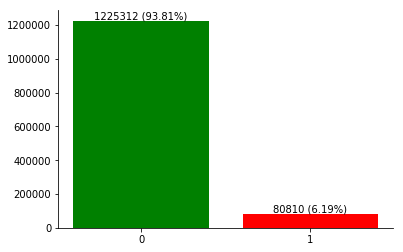

In [10]:
bars = plt.bar(range(2),p_n.target,color='gr')
plt.xticks([0,1])
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width() / 2, h,str(h)+' (%.2f%%)' % (h/len(train_raw)*100) , ha='center', va='bottom')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [11]:
ins_q = train_raw.question_text[train_raw.target==1]
s_q = train_raw.question_text[train_raw.target==0]

In [12]:
ins_q.sample(2,random_state=1).values

array(['Why do teenagers like to do incest?',
       "Why are Gujaratis so self-obsessed with their state and don't bother to see the beauty of other cultures and states?"],
      dtype=object)

In [13]:
s_q.sample(2,random_state=1).values

array(['How is 3-Hexanone produced?',
       'How do requirement management and requirement traceability compare and contrast?'],
      dtype=object)

## Frequencies

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [15]:
stop = stopwords.words('english')

In [16]:
question_text = train_raw.question_text

In [17]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub('', s).split()

In [18]:
def group(sin_text,ins_text):
    stop = stopwords.words('english')
    sin_words = sin_text.apply(tokenize)
    sins = [j for i in sin_words for j in i]
    sin_filtered = [w for w in sins if w not in stop]
    ins_words = ins_text.apply(tokenize)
    ins = [j for i in ins_words for j in i]
    ins_filtered = [w for w in ins if w not in stop]
    return sin_filtered, ins_filtered

    
#data_tokens = [tokenize(s) for s in question_text]

In [19]:
sin_f, ins_f = group(question_text[train_raw['target']==0],question_text[train_raw['target']==1])

In [20]:
bigram=list(ngrams(sin_f,2))

In [21]:
bigram_ins=list(ngrams(ins_f,2))

In [22]:
def print_top_20(text,ngram=1):
    freq = FreqDist(text)
    most_freq = freq.most_common(20)
    if ngram==1:
        words = [w[0] for w in most_freq]
    else:
        words = [' '.join(w[0]) for w in most_freq]
    num = [n[1] for n in most_freq]
    plt.barh(words,num,alpha=0.8)


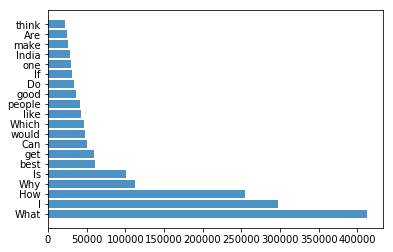

In [23]:
print_top_20(sin_f)

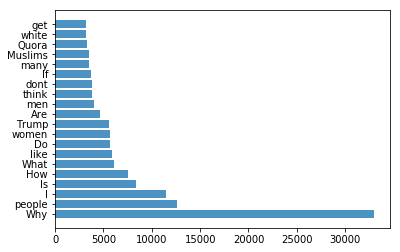

In [24]:
print_top_20(ins_f)

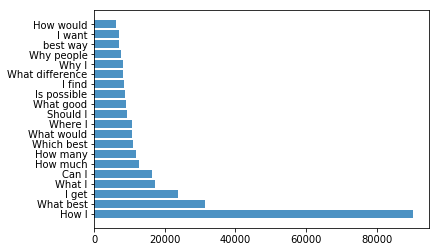

In [25]:
print_top_20(bigram,2)

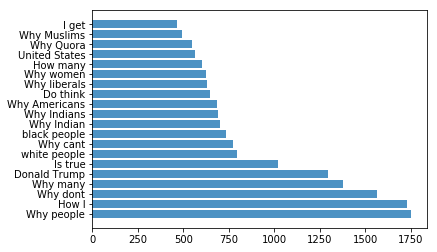

In [26]:
print_top_20(bigram_ins,2)

In [27]:
def wordcloud(text,stopwords,ngram=1):
    # text: when ngram>1, text should be dictionary
    if ngram==1:
        wordcloud = WordCloud(width=1400, height=800,background_color='black',stopwords=stop).generate(' '.join(text))
    else:
        wordcloud = WordCloud(width=1400, height=800,background_color='black',stopwords=stop).generate_from_frequencies(text)
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)

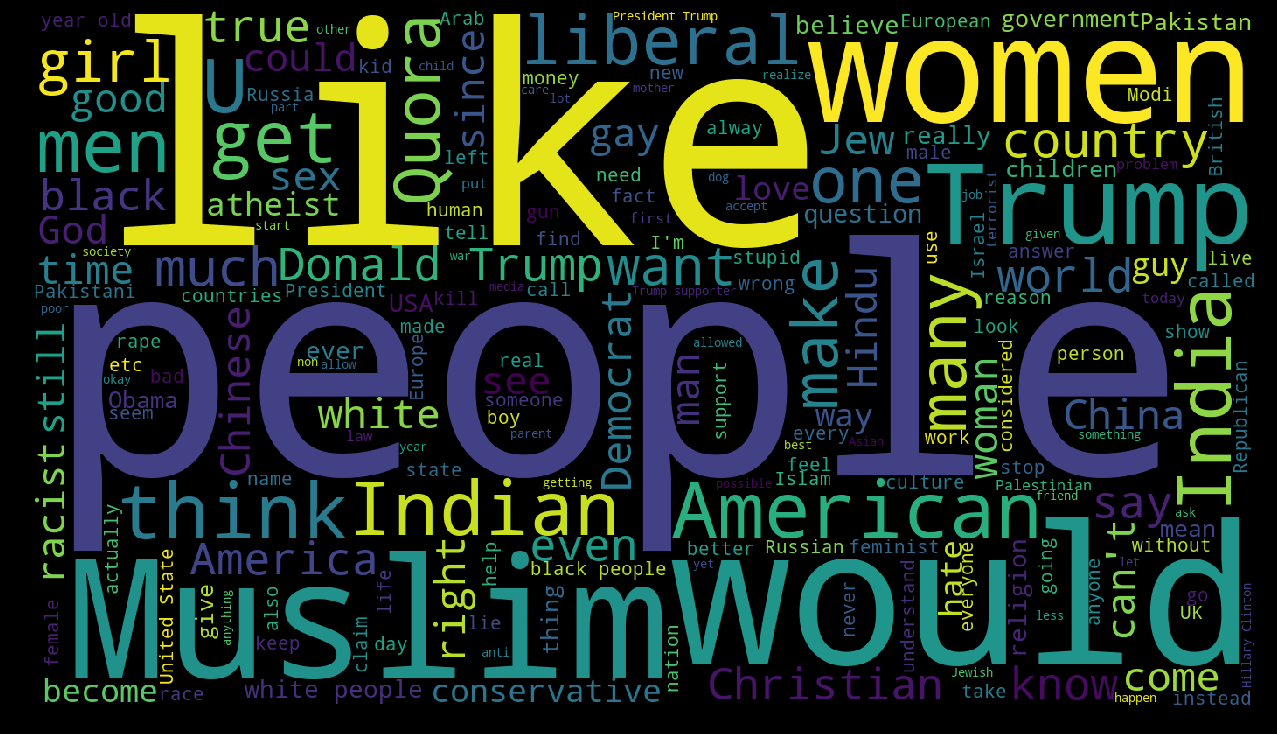

In [28]:
wordcloud(text=train_raw.question_text[train_raw['target']==1],stopwords=stop)

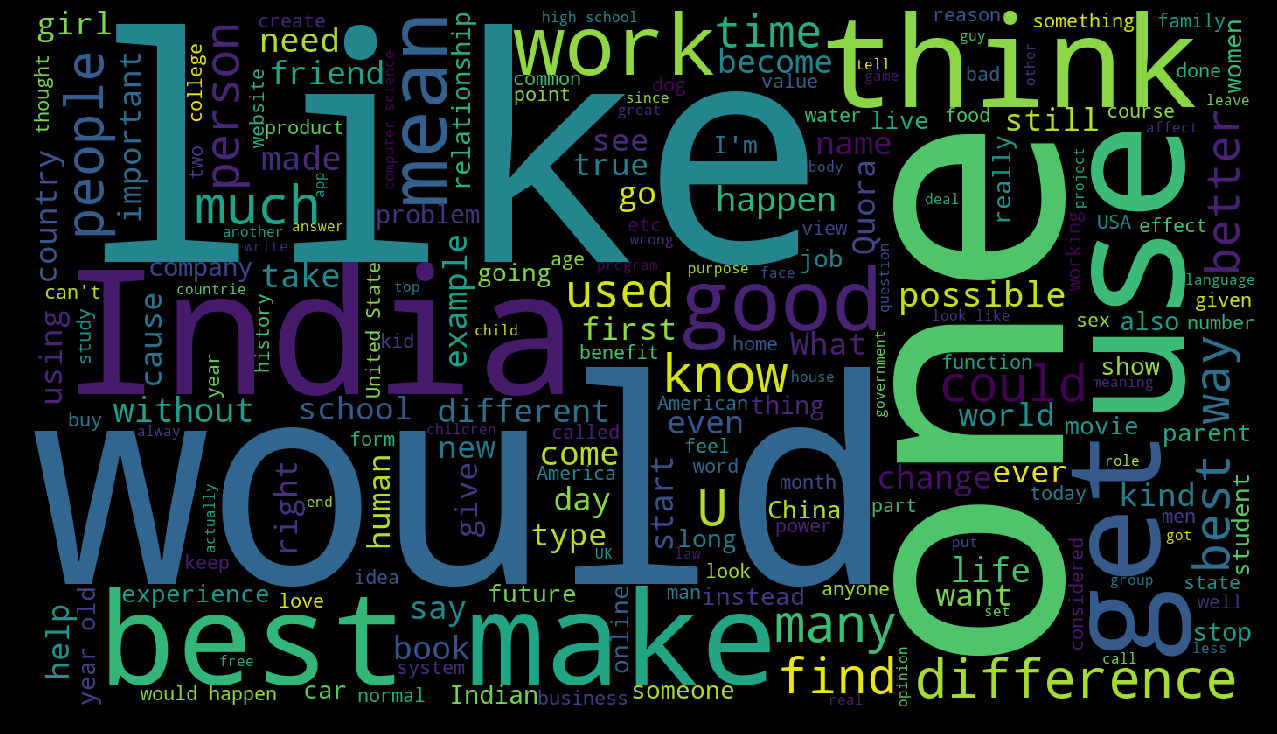

In [29]:
wordcloud(train_raw.question_text[train_raw['target']==0],stop)

In [30]:
freq_bi_top1000 = FreqDist(bigram_ins).most_common(1000)

In [31]:
text_dict = {}
 
listLen = len(freq_bi_top1000)
 
# Get the bigram and make a contiguous string for the dictionary key. 
# Set the key to the scored value. 
for i in range(listLen):
    text_dict['_'.join(freq_bi_top1000[i][0])] = freq_bi_top1000[i][1]

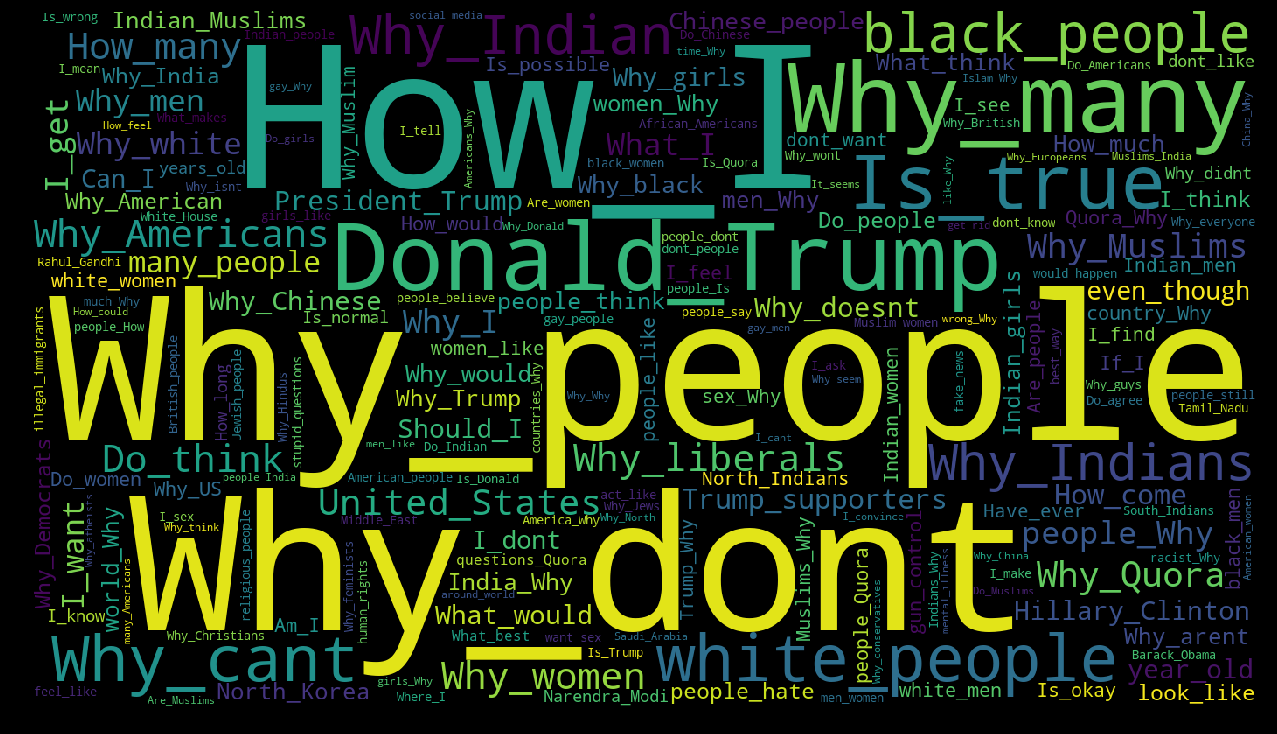

In [32]:
wordcloud(text_dict,stop,ngram=2)

# DATA ENGINEERING

In [33]:
class process:
    #two roadmaps :
        #1. initialize - split - dtm/tfidf
        #2. initialize - lem - split - dtm/tfidf

    def __init__(self,data):
        self.data = data
        self.question = data['question_text'].tolist()
        self.target=data['target'].values
        
    def lem(self):
        nltk.download('wordnet')
        from nltk.stem import WordNetLemmatizer
        question_text = self.data['question_text'] 
        question_token = question_text.apply(self.tokenize)
        lemmatizer = WordNetLemmatizer()
        self.question = []

        for line in question_token:           
            lemmatized = [lemmatizer.lemmatize(w,'v') for w in line]
            self.question.append(' '.join(lemmatized))
        
    def tokenize(self,s):                                                                     
        #s = self.data
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        return re_tok.sub('', s).split()
    
    def split(self,val_size=0.1):
        from sklearn.model_selection import train_test_split
        self.X_train,self.X_valid,self.y_train,self.y_valid = train_test_split(self.question,self.target,test_size = val_size)
        return self.y_train, self.y_valid
        
    def dtm(self,stop_words=None,ngram_range=(1,3), max_features=800000):
        veczr = CountVectorizer(tokenizer=self.tokenize,stop_words=stop_words,ngram_range=ngram_range, max_features=max_features)
        self.X_text = veczr.fit_transform(self.X_train)
        self.val_text = veczr.transform(self.X_valid)      
        return self.X_text, self.val_text
    
    def tfidf(self,stop_words=None,ngram_range=(1,3), max_features=800000): 
        tfi = TfidfVectorizer(tokenizer=self.tokenize,ngram_range=ngram_range, stop_words=stop_words,max_features=max_features)
    
        self.X_text = tfi.fit_transform(self.X_train)
        self.val_text = tfi.transform(self.X_valid)
        return self.X_text, self.val_text
    
class model():
    
    def __init__(self,X_text,y_train,val_text,y_valid):
        self.X = X_text
        self.y = y_train
        self.val_text = val_text
        self.y_valid = y_valid
        
    def plot_roc_curve(self, fpr, tpr, label=None): 
        plt.plot(self.fpr, self.tpr, linewidth=2, label=label) 
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    def condition(self,y_i):
        p=self.X[self.y==y_i].sum(0)
        return (p+1)/((self.y==y_i).sum()+1)
    
    def nb(self, binary = False, threshold=0):
        b = np.log((self.y==1).mean()/(self.y==0).mean())
        self.r = np.log(self.condition(1)/self.condition(0))
        prob_preds = self.val_text @ self.r.T + b
        if binary == True:
            self.X=self.X.sign()
            self.r = np.log(self.condition(1)/self.condition(0))
            prob_preds = self.val_text.sign() @ self.r.T + b
        cl_preds = [1 if i > threshold else 0 for i in prob_preds]
        return prob_preds,cl_preds
    
    def logreg(self, c=0.1, threshold=0.5):
        m_logi = LogisticRegression(dual=True, C=c)
        X_logit = self.X.copy()
        val_X_logit = self.val_text.copy()
        m_logi.fit(X_logit, self.y)
        prob_preds = m_logi.predict_proba(val_X_logit)[:,1]
        cl_preds = [1 if x > threshold else 0 for x in prob_preds]
        return prob_preds,cl_preds

    def nb_logreg(self, c=0.1,threshold=0.5):
        m_nblogi = LogisticRegression(dual=True, C=c)

        X_logit = self.X.multiply(self.r)
        val_X_logit = self.val_text.multiply(self.r)
        m_nblogi.fit(X_logit, self.y)
        prob_preds = m_nblogi.predict_proba(val_X_logit)[:,1]
        cl_preds = [1 if x > threshold else 0 for x in prob_preds]
        return prob_preds,cl_preds
    
    def metric(self,prob,cl):
        self.fpr, self.tpr, threshold = roc_curve(self.y_valid, prob)
        auc = roc_auc_score(self.y_valid,prob)
        self.plot_roc_curve(self.fpr,self.tpr)
        acc = (self.y_valid==cl).mean()
        f1 = f1_score(self.y_valid,cl)
        print(acc,f1,auc)
        #return acc,f1,auc

In [34]:
p = process(data)

In [35]:
y_train,y_valid = p.split()

In [36]:
len(y_train),len(y_valid),len(p.X_train)

(1175509, 130613, 1175509)

In [37]:
X_text,val_text = p.dtm()

In [38]:
m = model(X_text,y_train,val_text,y_valid)

In [39]:
prob, cl = m.nb(threshold=10)

0.8618743922886696 0.4377123266323827 0.9293248126190379


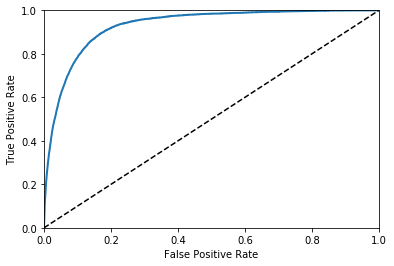

In [40]:
m.metric(prob,cl)

In [41]:
prob, cl = m.logreg()

C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9531287084746541 0.6392457277548615 0.9561227469153597


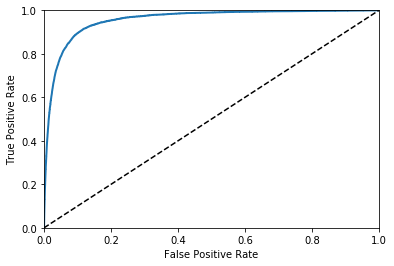

In [42]:
m.metric(prob,cl)

In [43]:
prob1, cl1 = m.logreg()

C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9529602719484278 0.6379066478076378 0.9559653478993302


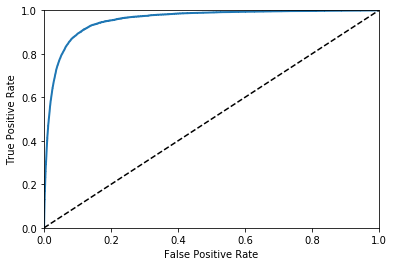

In [44]:
m.metric(prob1,cl1)

In [45]:
prob, cl = m.nb(binary=True, threshold=10)

0.8671265494246362 0.44501295129672863 0.930231920163045


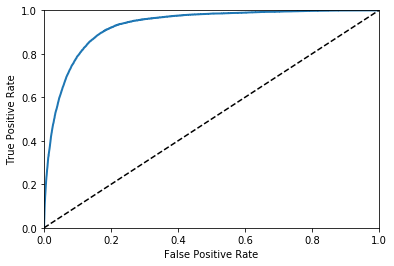

In [46]:
m.metric(prob,cl)

In [47]:
prob, cl = m.logreg()

C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9500356013566796 0.6345206093189965 0.9557653988629308


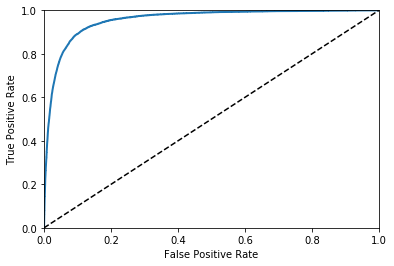

In [48]:
m.metric(prob,cl)

In [49]:
prob1, cl1 = m.nb_logreg()

C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9535191749672697 0.6453647993457562 0.9575912784499272


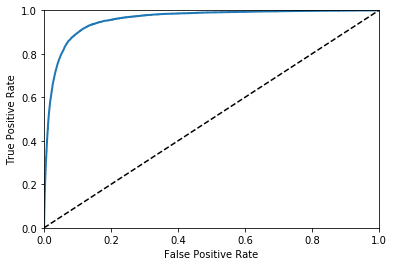

In [50]:
m.metric(prob1,cl1)